Ahyar


 Bergabung sejak 03 Jun 2020

 Kota Bandung, Jawa Barat

In [42]:
# import library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [43]:
df = pd.read_csv('/content/covid_19_indonesia_time_series_all.csv')
df.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,City or Regency,Province,Country,Continent,Island,Time Zone,Special Status,Total Regencies,Total Cities,Total Districts,Total Urban Villages,Total Rural Villages,Area (km2),Population,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths,Name,Item,Kind,Hidden
0,1/8/2020,ID-JI,Jawa Timur,9,3,1,5,9,5,10,-6,Province,NaN,Jawa Timur,Indonesia,Asia,Jawa,UTC+07:00,NaN,29,9.0,666,777.0,7724.0,47803,40479023,846.78,112.732941,-7.723346,0.22,0.22,0.07,0.12,55.56%,111.11%,NaN,NaN,NaN,NaN,NaN,NaN
1,1/9/2020,ID-JI,Jawa Timur,0,1,23,-24,9,6,33,-30,Province,NaN,Jawa Timur,Indonesia,Asia,Jawa,UTC+07:00,NaN,29,9.0,666,777.0,7724.0,47803,40479023,846.78,112.732941,-7.723346,0.00,0.22,0.02,0.15,66.67%,366.67%,0.0,0.33,NaN,NaN,NaN,NaN
2,1/10/2020,ID-JI,Jawa Timur,0,1,14,-15,9,7,47,-45,Province,NaN,Jawa Timur,Indonesia,Asia,Jawa,UTC+07:00,NaN,29,9.0,666,777.0,7724.0,47803,40479023,846.78,112.732941,-7.723346,0.00,0.22,0.02,0.17,77.78%,522.22%,1.0,1.00,NaN,NaN,NaN,NaN
3,1/11/2020,ID-JI,Jawa Timur,0,3,8,-11,9,10,55,-56,Province,NaN,Jawa Timur,Indonesia,Asia,Jawa,UTC+07:00,NaN,29,9.0,666,777.0,7724.0,47803,40479023,846.78,112.732941,-7.723346,0.00,0.22,0.07,0.25,111.11%,611.11%,1.0,3.00,NaN,NaN,NaN,NaN
4,1/12/2020,ID-JI,Jawa Timur,0,3,1,-4,9,13,56,-60,Province,NaN,Jawa Timur,Indonesia,Asia,Jawa,UTC+07:00,NaN,29,9.0,666,777.0,7724.0,47803,40479023,846.78,112.732941,-7.723346,0.00,0.22,0.07,0.32,144.44%,622.22%,1.0,1.00,NaN,NaN,NaN,NaN


In [44]:
#  mengecek apakah ada nilai yang hilang dari dataset
df.isnull().sum()

Date                               0
Location ISO Code                  0
Location                           0
New Cases                          0
New Deaths                         0
New Recovered                      0
New Active Cases                   0
Total Cases                        0
Total Deaths                       0
Total Recovered                    0
Total Active Cases                 0
Location Level                     0
City or Regency                16283
Province                         495
Country                            0
Continent                          0
Island                           495
Time Zone                        495
Special Status                 13890
Total Regencies                    0
Total Cities                     469
Total Districts                    0
Total Urban Villages             471
Total Rural Villages             496
Area (km2)                         0
Population                         0
Population Density                 0
L

In [45]:
# drop item yang tidak perlu
df.drop(["Location ISO Code", "New Cases", "New Deaths", "New Recovered", "New Active Cases", "Province", "Country", "Continent", "Island", "Time Zone", 
                "Special Status", "Total Regencies", "Total Cities", "Total Districts", "Total Urban Villages", "Total Rural Villages", "Area (km2)", 
                "New Cases per Million", "Total Cases per Million","New Deaths per Million", "Total Deaths per Million", "Case Fatality Rate",
                "Case Recovered Rate", "Growth Factor of New Cases","Growth Factor of New Deaths", "City or Regency"],axis=1,inplace=True)
df.head()

,Date,Location,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Population,Population Density,Longitude,Latitude,Name,Item,Kind,Hidden
0,1/8/2020,Jawa Timur,9,5,10,-6,Province,40479023,846.78,112.732941,-7.723346,NaN,NaN,NaN,NaN
1,1/9/2020,Jawa Timur,9,6,33,-30,Province,40479023,846.78,112.732941,-7.723346,NaN,NaN,NaN,NaN
2,1/10/2020,Jawa Timur,9,7,47,-45,Province,40479023,846.78,112.732941,-7.723346,NaN,NaN,NaN,NaN
3,1/11/2020,Jawa Timur,9,10,55,-56,Province,40479023,846.78,112.732941,-7.723346,NaN,NaN,NaN,NaN
4,1/12/2020,Jawa Timur,9,13,56,-60,Province,40479023,846.78,112.732941,-7.723346,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Datetime')

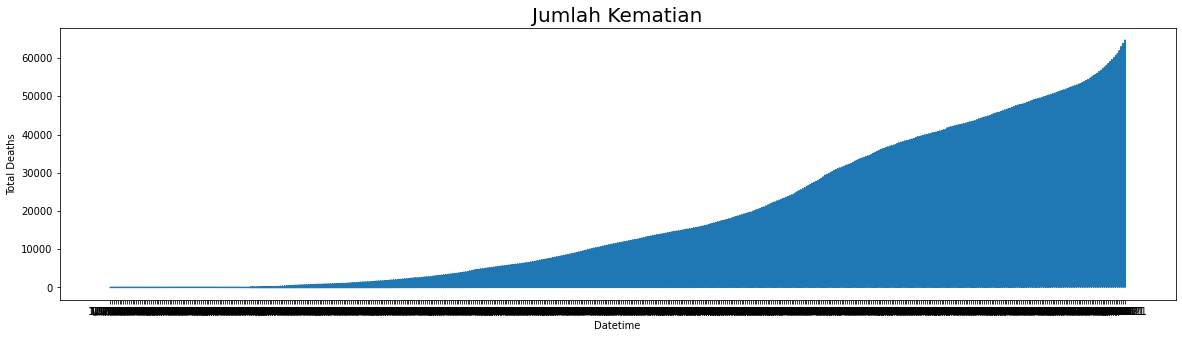

In [46]:
# menjadikan data array dan plot
dates = df['Date'].values
death  = df['Total Deaths'].values.astype('float32')

 
plt.figure(figsize=(20,5))
plt.plot(dates, death)
plt.title('Jumlah Kematian',
          fontsize=20);
plt.ylabel('Total Deaths')
plt.xlabel('Datetime')

In [47]:
# membagi data  Validation set sebesar 20% dari total dataset.
x_train, x_valid, y_train, y_valid = train_test_split(death, dates, train_size=0.8, test_size = 0.2, shuffle = False )


In [48]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  13026
Total Data Validation :  3257


In [49]:
# merubah data untuk diterima di model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [50]:
# Pemodelan Sequential
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [51]:
# Menghitung nilai 10% MAE
Mae = (df['Total Deaths'].max() - df['Total Deaths'].min()) * 10/100
print(Mae)

6463.1


In [52]:
# membuat callback dan penggunaan 10% dari skala data
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<6400 and logs.get('val_mae')<2750):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()


In [55]:
# menggunakan Learning Rate pada Optimize
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
65/65 [==============================] - 21s 270ms/step - loss: 825.7410 - mae: 826.2295 - val_loss: 2948.7285 - val_mae: 2949.2283
Epoch 2/100
65/65 [==============================] - 16s 242ms/step - loss: 825.0372 - mae: 825.5262 - val_loss: 2947.7600 - val_mae: 2948.2603
Epoch 3/100
65/65 [==============================] - 16s 239ms/step - loss: 823.9401 - mae: 824.4296 - val_loss: 2946.0288 - val_mae: 2946.5286
Epoch 4/100
65/65 [==============================] - 16s 244ms/step - loss: 822.1023 - mae: 822.5905 - val_loss: 2942.6887 - val_mae: 2943.1885
Epoch 5/100
65/65 [==============================] - 16s 247ms/step - loss: 818.9537 - mae: 819.4481 - val_loss: 2935.9888 - val_mae: 2936.4885
Epoch 6/100
65/65 [==============================] - 16s 239ms/step - loss: 814.0885 - mae: 814.5869 - val_loss: 2922.5093 - val_mae: 2923.0093
Epoch 7/100
65/65 [==============================] - 16s 246ms/step - loss: 808.4415 - mae: 808.9400 - val_loss: 2899.6780 - val_mae: 29

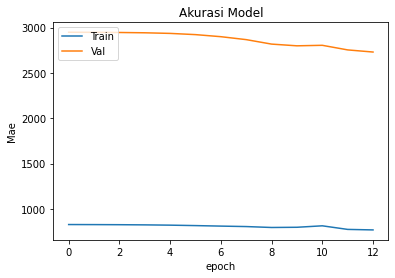

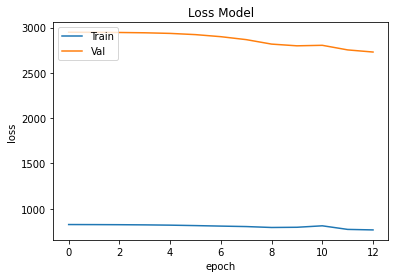

In [56]:
# Plot Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()